In [ ]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML

from langdetect import detect
import re

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

Version:      2.4.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

## GET DATA

In [8]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [9]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [10]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '337627',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/hItZjdDTNuaCZ7fEztwcUQ__thumb/img/Ov6eWR87PZ2O1XYQtXMO6KvfzOg=/fit-in/200x150/filters:strip_icc()/pic6153324.jpg',
  'name': 'Voidfall',
  'yearpublished': '2022'},
 {'id': '312484',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/6GqH14TJJhza86BX5HCLEQ__thumb/img/J8SVmGOJXZGxNjkT3xYNQU7Haxg=/fit-in/200x150/filters:strip_icc()/pic5674958.jpg',
  'name': 'Lost Ruins of Arnak',
  'yearpublished': '2020'}]

In [11]:
try:
    comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

<ipython-input-11-3c366f14faf3>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")


missing csv file, getting new data using API...
page number = 10 (max: 100, len: 23)
page number = 20 (max: 100, len: 13)
page number = 30 (max: 100, len: 10)
page number = 40 (max: 100, len: 8)
page number = 50 (max: 100, len: 4)
page number = 60 (max: 100, len: 4)
page number = 70 (max: 100, len: 3)
page number = 80 (max: 100, len: 3)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 0, len: 1)
comments_df shape: (83719, 4)


<ipython-input-11-3c366f14faf3>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)


,id,username,rating,value
0,337627,BGFreakDag2PT,N/A,On Radar
1,337627,Bstalf21,N/A,KS fall?
2,337627,bucklen_uk,N/A,I don't rate my own games (doesn't seem approp...
3,337627,carlcorey,N/A,"Turczi / Mindclash with O'Toole design, intere..."
4,337627,Dahanil,N/A,David Turczi + Ian O'Toole - tasty combination!
...,...,...,...,...
83714,167791,z_zadar,9,Some games are so much fun. Others can be a li...
83715,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
83716,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
83717,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [12]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  

In [13]:
comments_df["value"] = comments_df["value"].astype(str)

In [14]:
# REMOVE URLs FROM COMMENTS

In [15]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [16]:
# REMOVE SHORT COMMENTS
def remove_short_comments(df: pd.DataFrame, min_len=25, method='unrated'):
    if method not in ['unrated', 'rated', 'both']:
        raise AttributeError(f"method {method} not allowed")
    df_local = df.copy()    
    df_local['comment_len'] = [len(re.findall("[A-Za-z]", v)) for v in df_local['value'].values]
    if method == 'rated':
        df_local = df_local.query('(comment_len>@min_len and rating != "N/A") or rating == "N/A"')
    elif method == 'unrated':
        df_local = df_local.query('(comment_len>@min_len and rating == "N/A") or rating != "N/A"')
    else:
        df_local = df_local.query('comment_len>@min_len')
    print(f"removed {len(df)-len(df_local)} for 'remove_short_comments' - min len: {min_len} - method: {method}")
    return df_local.reset_index(drop=True)

In [17]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 14436 for 'remove_short_comments' - min len: 25 - method: unrated


In [18]:
# REMOVE NON ENGLISH COMMENTS

In [19]:
# !conda install -c conda-forge langdetect

In [20]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [21]:
# comments_df = add_comments_lang(comments_df)

In [22]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [23]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10         14206
9          13173
8          10573
N/A         6031
7           5727
           ...  
8.325          1
7.61           1
3.4            1
8.46667        1
9.28           1
Name: rating, Length: 485, dtype: int64

In [24]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(63252, 5)

In [25]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6031, 5)

## CREATE TRAINING AND VALIDATION DATA

In [26]:
# use rated comments (reviews) to train the model

In [27]:
rated_comments = rated_comments.sample(frac=1)

In [28]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [29]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'LOVE This, played at my Uncles house multiple times!!!'

In [30]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


"I don't know why I don't enjoy this so much. It felt limiting in my choices, like there was always one option that was the best, and I would be punished if I didn't do it. Also very slow-paced."

In [31]:
# create validation dataset from training
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

## COMPOSE MODEL

In [32]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:2])

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.1982231 , -0.14844386,  0.00571075, -0.13236518, -0.01729318,
         0.06396857,  0.04414018, -0.29200852,  0.04114552, -0.19894914,
        -0.0205414 , -0.19050398,  0.1287826 ,  0.19119631, -0.13379046,
        -0.04777165,  0.08088499, -0.03185825, -0.31423926,  0.03954934,
        -0.02852826, -0.14475286, -0.09696018, -0.06685486, -0.12593962,
        -0.22618076, -0.15363193, -0.10452226,  0.05022716,  0.13285804,
        -0.00488677,  0.09790319, -0.05383318, -0.04996517,  0.06527376,
         0.10831552,  0.22208852,  0.0629539 , -0.03362856, -0.10679161,
         0.17410794, -0.0263038 , -0.13179651,  0.15667525, -0.11687353,
         0.13362777, -0.30371124,  0.02737263,  0.22512126,  0.14258751],
       [ 0.28092515,  0.05843626,  0.05460948,  0.39815843,  0.07768856,
        -0.04987588,  0.14252174, -0.12837948,  0.05669588, -0.10312901,
         0.09913287,  0.07447433, -0.08775353,  0.2265547 ,  0.33778378,
 

In [33]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
)

## TRAINING MODEL 

In [35]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
    ]
)

Epoch 1/40
93/93 - 8s - loss: 0.4999 - accuracy: 0.8189 - val_loss: 0.3951 - val_accuracy: 0.8580
Epoch 2/40
93/93 - 5s - loss: 0.3318 - accuracy: 0.8730 - val_loss: 0.3183 - val_accuracy: 0.8783
Epoch 3/40
93/93 - 5s - loss: 0.2675 - accuracy: 0.8954 - val_loss: 0.3014 - val_accuracy: 0.8827
Epoch 4/40
93/93 - 5s - loss: 0.2297 - accuracy: 0.9101 - val_loss: 0.3007 - val_accuracy: 0.8805
Epoch 5/40
93/93 - 5s - loss: 0.2020 - accuracy: 0.9224 - val_loss: 0.3172 - val_accuracy: 0.8778
Epoch 6/40
93/93 - 5s - loss: 0.1801 - accuracy: 0.9324 - val_loss: 0.3295 - val_accuracy: 0.8740
Epoch 7/40
93/93 - 5s - loss: 0.1616 - accuracy: 0.9405 - val_loss: 0.3472 - val_accuracy: 0.8695
Epoch 8/40
93/93 - 5s - loss: 0.1465 - accuracy: 0.9471 - val_loss: 0.3698 - val_accuracy: 0.8661


In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [38]:
epochs = range(1, len(acc) + 1) 

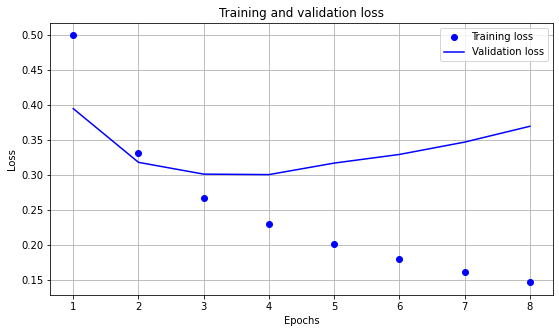

In [39]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

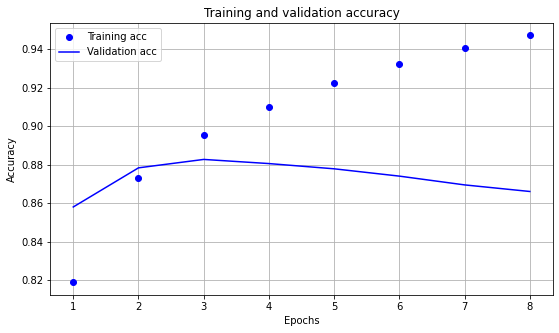

In [40]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [41]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [42]:
inputs = x_train[:10]
outputs = y_train[:10]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results, outputs)

input:
"fully painted "table top" quality"
score: 0.985952
actual value:1

input:
"This game does not give you the tools to overcome bad draws. Too bad, as it is actually very close to being a phenomenal game, if only it had been tweaked a tad. Great game to play with a non-gamer, though, although I stil prefer Everdell in that regard."
score: 0.236053
actual value:0

input:
"The game is entertaining. But FFG has really gone all out to make your experience more about how much money they can get from you than about making it a good game out of the box."
score: 0.987885
actual value:1

input:
"Hey "
score: 0.238413
actual value:0

input:
"great game, plenty of tough decisions, absolutely beautiful artwork"
score: 0.996106
actual value:1

input:
"want to try again (don't want to teach)"
score: 0.389453
actual value:1

input:
"great game, just wish it got more plays :)"
score: 0.999018
actual value:1

input:
"Tableau, Tactical"
score: 0.973485
actual value:1

input:
"Excellent. Will play i

In [43]:
## APPLY MODEL ON NON-RATED COMMENTS

In [44]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value.astype(str)))))
print_my_examples(list(not_rated_comments.value), results, limit=25)

input:
"Fathers Day 2018. From Amazon $79.99! -5% with Amazon Prime Card"
score: 0.999834

input:
"* Gioco strategico. Cooperativo * 1-4 giocatori. Ideale per 2 * 90-120 minuti"
score: 0.999512

input:
"Currently own, but have a few games to get plays in before I can learn this."
score: 0.807638

input:
"Collectors edition includes expansions Extra Extra, Legends, and Rugwort pack, as well as the premium components. "
score: 0.998669

input:
"Friend strategy game. 4 factions w/ totally different objectives. "
score: 0.924946

input:
"P1-4 B2 D4.01 T4 New, not sleeved RB not read Played 0 At Storage With Expansion"
score: 0.825255

input:
"With BGG food bits and European expansion  "
score: 0.969372

input:
"Core game is priced as if it came with a small campaign and decent insert but it doesn't. "
score: 0.898198

input:
"Kickstarter version with Late Arrivals expansion + promos "
score: 0.995688

input:
"Cool living card game with deckbuilding."
score: 0.997405

input:
"---- Including

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [45]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124839 |          7.97 |            110 |
| 162886 |          8.35 |           3497 |
| 167355 |          8.41 |           1782 |
| 167791 |          8.21 |           8209 |
| 169427 |          8.58 |            215 |


In [46]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [47]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 124839 |          8.30 |             23 |
| 162886 |          8.65 |            307 |
| 167355 |          8.86 |            214 |
| 167791 |          8.85 |            438 |
| 169427 |          8.84 |             72 |


In [48]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [49]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/hItZjdD...","<a href=""https://boardgamegeek.com/boardgame/3...",10.000000,8.466667,8.685714,1,2022
1,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.916983,8.903030,8.006010,2,2020
2,"<img src=""https://cf.geekdo-images.com/SAKzHYV...","<a href=""https://boardgamegeek.com/boardgame/3...",7.000000,9.766667,9.075000,3,2022
3,"<img src=""https://cf.geekdo-images.com/PhjygpW...","<a href=""https://boardgamegeek.com/boardgame/3...",8.116883,8.483333,8.153528,4,2020
4,"<img src=""https://cf.geekdo-images.com/eUiju5S...","<a href=""https://boardgamegeek.com/boardgame/3...",8.657895,8.618182,8.643333,5,2021


In [50]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [51]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,10.000000,8.466667,8.685714,1,2022
2,,Lost Ruins of Arnak,7.916983,8.903030,8.006010,2,2020
3,,Mosaic: A Story of Civilization,7.000000,9.766667,9.075000,3,2022
4,,Dune: Imperium,8.116883,8.483333,8.153528,4,2020
5,,Stationfall,8.657895,8.618182,8.643333,5,2021


In [52]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,10.000000,8.466667,8.685714,1,2022
2,,Chronicles of Drunagor: Age of Darkness,9.500000,9.445455,9.485714,18,2021
3,,Eclipse: Second Dawn for the Galaxy,8.744153,8.743373,8.744028,37,2020
4,,Brass: Birmingham,8.689960,8.969264,8.715809,27,2018
5,,Stationfall,8.657895,8.618182,8.643333,5,2021


In [53]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Chronicles of Drunagor: Age of Darkness,9.500000,9.445455,9.485714,18,2021
2,,Mosaic: A Story of Civilization,7.000000,9.766667,9.075000,3,2022
3,,Merchants Cove,8.307843,9.333333,8.770968,6,2021
4,,Eclipse: Second Dawn for the Galaxy,8.744153,8.743373,8.744028,37,2020
5,,Brass: Birmingham,8.689960,8.969264,8.715809,27,2018


In [54]:
# model.save('saved_model\my_model')

In [55]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [56]:
# some examples on "long" comments vs short comments

In [59]:
# some long comments
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')
results = tf.sigmoid(model.predict(tf.constant(list(some_long_comments.value))))
print_my_examples(list(some_long_comments.value), results)

input:
"Only played once. Not a fan of the theme. I don't feel like I can rate after only playing once, so I'm not going to."
score: 0.079213

input:
"I was having great expectations from this title, but it fell short on implementation.  I felt bored halfway through the first game, like my decisions didn't matter as much as luck from the draw."
score: 0.240989

input:
"I've only played a few scenarios. I'm considering selling only because of how ambitious the game is and I'm not sure I'll be able to finish it."
score: 0.389806

input:
"Looking for players! I have not played it yet but I do own a Kickstarter Copy.  Message me if you would like to play..especially if you can help with the rules! LOL"
score: 0.732224

input:
"At this time, this game will realistically not get played due to the required time commitment. Maybe in the future. Will not get now."
score: 0.765046

input:
"Playing Time: 1-2.5 hours Best with 2-4 players (4 max) Pros: Asymmetric player abilities, satisfying engin